# Baseline Model Cascade
**Objective:** Build a cascade of progressively sophisticated baseline models to establish performance benchmarks.

**Strategy:**
1. **Baseline 1 - Global Mean:** Predict overall mean pickups (ignores all features)
2. **Baseline 2 - Hour-of-Day Mean:** Predict mean pickups per zone-hour (captures hourly seasonality)
3. **Baseline 3 - 24h Lag:** Use previous day same hour (captures day-to-day persistence)
4. **Baseline 4 - Rolling Average:** Use 7-day rolling average for same hour (smooths noise)

**Train/Val/Test Split:** Jan-Oct 2024 / Nov 2024 / Dec 2024 (temporal split to prevent leakage)

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Load pre-aggregated hourly demand data from SQLite
db_path = Path('../data/processed/taxi.db')
conn = sqlite3.connect(db_path)

query = """
    SELECT 
        pickup_hour,
        pu_location_id as zone_id,
        trips as pickups
    FROM hourly_demand
    WHERE pickup_hour >= '2024-01-01' AND pickup_hour < '2025-01-01'
    ORDER BY pickup_hour, zone_id
"""

df = pd.read_sql_query(query, conn)
conn.close()

# Convert to datetime
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])

# Extract temporal features
df['hour'] = df['pickup_hour'].dt.hour
df['day_of_week'] = df['pickup_hour'].dt.dayofweek
df['month'] = df['pickup_hour'].dt.month
df['date'] = df['pickup_hour'].dt.date

# Convert zone_id to int (handle missing values as needed)
df['zone_id'] = df['zone_id'].astype(float).astype(int)

print(f"Loaded {len(df):,} zone-hour records")
print(f"Date range: {df['pickup_hour'].min()} to {df['pickup_hour'].max()}")
print(f"Unique zones: {df['zone_id'].nunique()}")
df.head()

Loaded 1,062,063 zone-hour records
Date range: 2024-01-01 00:00:00 to 2024-12-31 23:00:00
Unique zones: 263


,pickup_hour,zone_id,pickups,hour,day_of_week,month,date
0,2024-01-01,10,6,0,0,1,2024-01-01
1,2024-01-01,100,10,0,0,1,2024-01-01
2,2024-01-01,101,1,0,0,1,2024-01-01
3,2024-01-01,102,1,0,0,1,2024-01-01
4,2024-01-01,107,182,0,0,1,2024-01-01


In [7]:
# Temporal train/val/test split (no data leakage)
train = df[df['month'] <= 10].copy()  # Jan-Oct 2024
val = df[df['month'] == 11].copy()     # Nov 2024
test = df[df['month'] == 12].copy()    # Dec 2024

print(f"Train: {len(train):,} records ({train['pickup_hour'].min()} to {train['pickup_hour'].max()})")
print(f"Val:   {len(val):,} records ({val['pickup_hour'].min()} to {val['pickup_hour'].max()})")
print(f"Test:  {len(test):,} records ({test['pickup_hour'].min()} to {test['pickup_hour'].max()})")

Train: 874,706 records (2024-01-01 00:00:00 to 2024-10-31 23:00:00)
Val:   94,081 records (2024-11-01 00:00:00 to 2024-11-30 23:00:00)
Test:  93,276 records (2024-12-01 00:00:00 to 2024-12-31 23:00:00)


## 2. Baseline 1: Global Mean Model
**Logic:** Predict the overall mean pickups across all zones and hours (ignores all features).

In [8]:
# Baseline 1: Global Mean
global_mean = train['pickups'].mean()

val['pred_global_mean'] = global_mean
test['pred_global_mean'] = global_mean

# Evaluate
mae_val_b1 = mean_absolute_error(val['pickups'], val['pred_global_mean'])
rmse_val_b1 = np.sqrt(mean_squared_error(val['pickups'], val['pred_global_mean']))

print(f"Baseline 1 - Global Mean: {global_mean:.2f} pickups/zone-hour")
print(f"  Val MAE:  {mae_val_b1:.2f}")
print(f"  Val RMSE: {rmse_val_b1:.2f}")

Baseline 1 - Global Mean: 38.70 pickups/zone-hour
  Val MAE:  50.51
  Val RMSE: 78.55


## 3. Baseline 2: Hour-of-Day Mean Model
**Logic:** Predict mean pickups per zone-hour combination (captures hourly seasonality identified in EDA).

In [12]:
# Baseline 2: Hour-of-Day Mean (seasonal pattern)
hourly_zone_mean = train.groupby(['zone_id', 'hour'])['pickups'].mean().reset_index()
hourly_zone_mean.columns = ['zone_id', 'hour', 'pred_hourly_mean']

# Use the original val/test dataframes (no previous predictions)
val_predictions_b2 = val[['pickup_hour', 'zone_id', 'pickups', 'hour']].merge(
    hourly_zone_mean, on=['zone_id', 'hour'], how='left'
)
test_predictions_b2 = test[['pickup_hour', 'zone_id', 'pickups', 'hour']].merge(
    hourly_zone_mean, on=['zone_id', 'hour'], how='left'
)

# Fill missing zone-hour combinations with global mean
val_predictions_b2['pred_hourly_mean'] = val_predictions_b2['pred_hourly_mean'].fillna(global_mean)
test_predictions_b2['pred_hourly_mean'] = test_predictions_b2['pred_hourly_mean'].fillna(global_mean)

# Evaluate
mae_val_b2 = mean_absolute_error(val_predictions_b2['pickups'], val_predictions_b2['pred_hourly_mean'])
rmse_val_b2 = np.sqrt(mean_squared_error(val_predictions_b2['pickups'], val_predictions_b2['pred_hourly_mean']))

print(f"Baseline 2 - Hour-of-Day Mean:")
print(f"  Val MAE:  {mae_val_b2:.2f} (Δ {mae_val_b1 - mae_val_b2:+.2f} vs B1)")
print(f"  Val RMSE: {rmse_val_b2:.2f} (Δ {rmse_val_b1 - rmse_val_b2:+.2f} vs B1)")

Baseline 2 - Hour-of-Day Mean:
  Val MAE:  11.71 (Δ +38.80 vs B1)
  Val RMSE: 29.82 (Δ +48.72 vs B1)


## 4. Baseline 3: 24h-Lag Model
**Logic:** Use previous day same hour as prediction (captures day-to-day persistence).

In [14]:
# Baseline 3: 24h-Lag (yesterday's value)
# First aggregate to ensure unique zone-hour combinations
df_agg = df.groupby(['pickup_hour', 'zone_id']).agg({'pickups': 'sum'}).reset_index()

# Create a complete time grid to handle missing zone-hours
all_zones = df_agg['zone_id'].unique()
all_hours = pd.date_range(start=df_agg['pickup_hour'].min(), end=df_agg['pickup_hour'].max(), freq='h')
full_grid = pd.MultiIndex.from_product([all_hours, all_zones], names=['pickup_hour', 'zone_id'])
df_complete = df_agg.set_index(['pickup_hour', 'zone_id']).reindex(full_grid, fill_value=0).reset_index()

# Add temporal features back
df_complete['hour'] = df_complete['pickup_hour'].dt.hour
df_complete['month'] = df_complete['pickup_hour'].dt.month

# Create 24h lag
df_complete = df_complete.sort_values(['zone_id', 'pickup_hour'])
df_complete['lag_24h'] = df_complete.groupby('zone_id')['pickups'].shift(24)

# Extract validation and test sets with lag
val_complete = df_complete[df_complete['month'] == 11][['pickup_hour', 'zone_id', 'pickups', 'lag_24h']].copy()
test_complete = df_complete[df_complete['month'] == 12][['pickup_hour', 'zone_id', 'pickups', 'lag_24h']].copy()

# Merge with hourly mean for fallback
val_predictions_b3 = val_complete.merge(val_predictions_b2[['pickup_hour', 'zone_id', 'pred_hourly_mean']], on=['pickup_hour', 'zone_id'])
test_predictions_b3 = test_complete.merge(test_predictions_b2[['pickup_hour', 'zone_id', 'pred_hourly_mean']], on=['pickup_hour', 'zone_id'])

# Use lag where available, fallback to hourly mean
val_predictions_b3['pred_lag_24h'] = val_predictions_b3['lag_24h'].fillna(val_predictions_b3['pred_hourly_mean'])
test_predictions_b3['pred_lag_24h'] = test_predictions_b3['lag_24h'].fillna(test_predictions_b3['pred_hourly_mean'])

# Evaluate
mae_val_b3 = mean_absolute_error(val_predictions_b3['pickups'], val_predictions_b3['pred_lag_24h'])
rmse_val_b3 = np.sqrt(mean_squared_error(val_predictions_b3['pickups'], val_predictions_b3['pred_lag_24h']))

print(f"Baseline 3 - 24h-Lag:")
print(f"  Val MAE:  {mae_val_b3:.2f} (Δ {mae_val_b2 - mae_val_b3:+.2f} vs B2)")
print(f"  Val RMSE: {rmse_val_b3:.2f} (Δ {rmse_val_b2 - rmse_val_b3:+.2f} vs B2)")

Baseline 3 - 24h-Lag:
  Val MAE:  11.78 (Δ -0.07 vs B2)
  Val RMSE: 31.51 (Δ -1.68 vs B2)


## 5. Baseline 4: Rolling Average Model
**Logic:** Use 7-day rolling average for same hour (smooths day-to-day noise while preserving trends).

In [15]:
# Baseline 4: 7-day rolling average (168 hours = 7 days * 24 hours)
df_complete = df_complete.sort_values(['zone_id', 'pickup_hour'])
df_complete['rolling_7d'] = df_complete.groupby('zone_id')['pickups'].transform(
    lambda x: x.shift(24).rolling(window=168, min_periods=1).mean()
)

# Extract validation and test sets with rolling average
val_complete = df_complete[df_complete['month'] == 11][['pickup_hour', 'zone_id', 'pickups', 'rolling_7d']].copy()
test_complete = df_complete[df_complete['month'] == 12][['pickup_hour', 'zone_id', 'pickups', 'rolling_7d']].copy()

# Merge with hourly mean for fallback
val_predictions_b4 = val_complete.merge(val_predictions_b2[['pickup_hour', 'zone_id', 'pred_hourly_mean']], on=['pickup_hour', 'zone_id'])
test_predictions_b4 = test_complete.merge(test_predictions_b2[['pickup_hour', 'zone_id', 'pred_hourly_mean']], on=['pickup_hour', 'zone_id'])

# Use rolling average where available, fallback to hourly mean
val_predictions_b4['pred_rolling_7d'] = val_predictions_b4['rolling_7d'].fillna(val_predictions_b4['pred_hourly_mean'])
test_predictions_b4['pred_rolling_7d'] = test_predictions_b4['rolling_7d'].fillna(test_predictions_b4['pred_hourly_mean'])

# Evaluate
mae_val_b4 = mean_absolute_error(val_predictions_b4['pickups'], val_predictions_b4['pred_rolling_7d'])
rmse_val_b4 = np.sqrt(mean_squared_error(val_predictions_b4['pickups'], val_predictions_b4['pred_rolling_7d']))

print(f"Baseline 4 - 7-Day Rolling Average:")
print(f"  Val MAE:  {mae_val_b4:.2f} (Δ {mae_val_b3 - mae_val_b4:+.2f} vs B3)")
print(f"  Val RMSE: {rmse_val_b4:.2f} (Δ {rmse_val_b3 - rmse_val_b4:+.2f} vs B3)")

Baseline 4 - 7-Day Rolling Average:
  Val MAE:  23.35 (Δ -11.57 vs B3)
  Val RMSE: 52.18 (Δ -20.67 vs B3)


## 6. Baseline Comparison & Final Evaluation

In [16]:
# Compile all baseline results
results = pd.DataFrame({
    'Model': ['B1: Global Mean', 'B2: Hour-of-Day Mean', 'B3: 24h-Lag', 'B4: 7-Day Rolling Avg'],
    'Val MAE': [mae_val_b1, mae_val_b2, mae_val_b3, mae_val_b4],
    'Val RMSE': [rmse_val_b1, rmse_val_b2, rmse_val_b3, rmse_val_b4]
})

results['MAE Improvement'] = results['Val MAE'].iloc[0] - results['Val MAE']
results['MAE % Reduction'] = (results['MAE Improvement'] / results['Val MAE'].iloc[0] * 100).round(1)

print("\n" + "="*70)
print("BASELINE CASCADE RESULTS (Validation Set)")
print("="*70)
print(results.to_string(index=False))
print("="*70)

# Identify best baseline
best_model_idx = results['Val MAE'].idxmin()
print(f"\n✓ Best Baseline: {results.loc[best_model_idx, 'Model']}")
print(f"  MAE: {results.loc[best_model_idx, 'Val MAE']:.2f}")
print(f"  RMSE: {results.loc[best_model_idx, 'Val RMSE']:.2f}")


BASELINE CASCADE RESULTS (Validation Set)
                Model   Val MAE  Val RMSE  MAE Improvement  MAE % Reduction
      B1: Global Mean 50.510953 78.548985         0.000000              0.0
 B2: Hour-of-Day Mean 11.713614 29.824038        38.797340             76.8
          B3: 24h-Lag 11.780700 31.507738        38.730254             76.7
B4: 7-Day Rolling Avg 23.349050 52.181226        27.161903             53.8

✓ Best Baseline: B2: Hour-of-Day Mean
  MAE: 11.71
  RMSE: 29.82


In [17]:
# Test set evaluation for all baselines
test_mae_b1 = mean_absolute_error(test['pickups'], test['pred_global_mean'])
test_mae_b2 = mean_absolute_error(test_predictions_b2['pickups'], test_predictions_b2['pred_hourly_mean'])
test_mae_b3 = mean_absolute_error(test_predictions_b3['pickups'], test_predictions_b3['pred_lag_24h'])
test_mae_b4 = mean_absolute_error(test_predictions_b4['pickups'], test_predictions_b4['pred_rolling_7d'])

test_rmse_b1 = np.sqrt(mean_squared_error(test['pickups'], test['pred_global_mean']))
test_rmse_b2 = np.sqrt(mean_squared_error(test_predictions_b2['pickups'], test_predictions_b2['pred_hourly_mean']))
test_rmse_b3 = np.sqrt(mean_squared_error(test_predictions_b3['pickups'], test_predictions_b3['pred_lag_24h']))
test_rmse_b4 = np.sqrt(mean_squared_error(test_predictions_b4['pickups'], test_predictions_b4['pred_rolling_7d']))

test_results = pd.DataFrame({
    'Model': ['B1: Global Mean', 'B2: Hour-of-Day Mean', 'B3: 24h-Lag', 'B4: 7-Day Rolling Avg'],
    'Test MAE': [test_mae_b1, test_mae_b2, test_mae_b3, test_mae_b4],
    'Test RMSE': [test_rmse_b1, test_rmse_b2, test_rmse_b3, test_rmse_b4]
})

print("\n" + "="*70)
print("TEST SET PERFORMANCE")
print("="*70)
print(test_results.to_string(index=False))
print("="*70)
print(f"\n✓ Best on Test: {test_results.loc[test_results['Test MAE'].idxmin(), 'Model']}")
print(f"  Test MAE:  {test_results['Test MAE'].min():.2f}")
print(f"  Test RMSE: {test_results.loc[test_results['Test MAE'].idxmin(), 'Test RMSE']:.2f}")


TEST SET PERFORMANCE
                Model  Test MAE  Test RMSE
      B1: Global Mean 50.794710  79.184480
 B2: Hour-of-Day Mean 13.776460  33.360902
          B3: 24h-Lag 11.209454  28.619715
B4: 7-Day Rolling Avg 24.225677  53.020210

✓ Best on Test: B3: 24h-Lag
  Test MAE:  11.21
  Test RMSE: 28.62


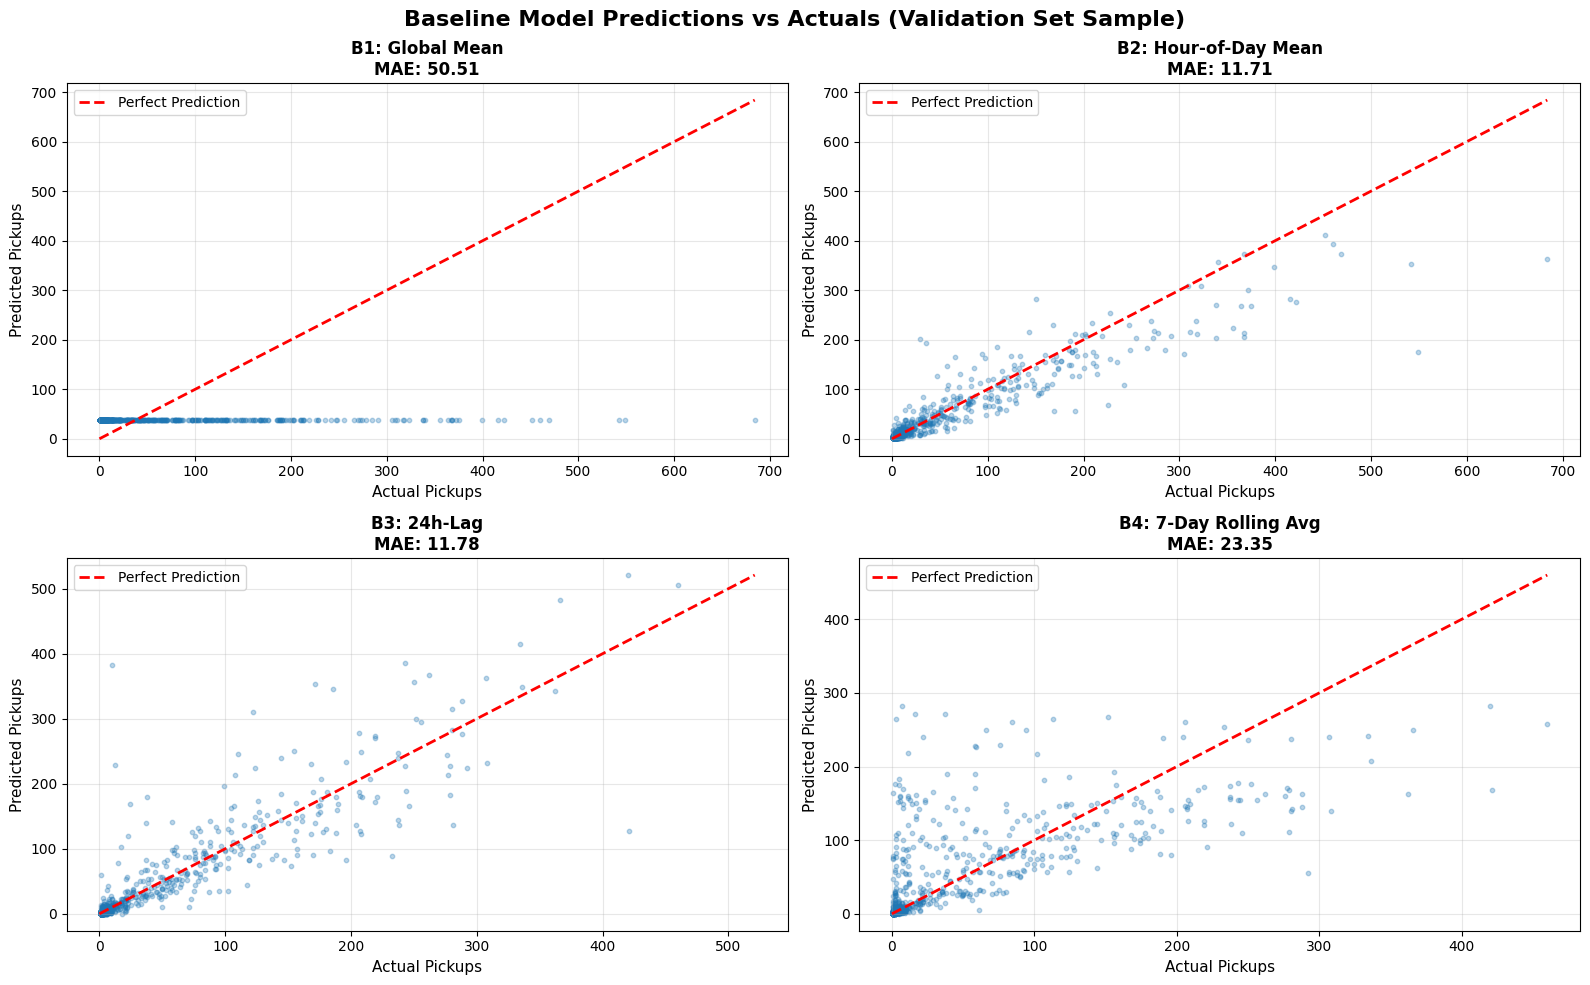

In [18]:
# Visualize predictions vs actuals for all baselines
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Baseline Model Predictions vs Actuals (Validation Set Sample)', fontsize=16, fontweight='bold')

# Sample 1000 random predictions for visualization
sample_indices = val_predictions_b2.sample(n=min(1000, len(val_predictions_b2)), random_state=42).index

models = [
    ('B1: Global Mean', val[val.index.isin(sample_indices)], 'pred_global_mean', mae_val_b1),
    ('B2: Hour-of-Day Mean', val_predictions_b2.loc[sample_indices], 'pred_hourly_mean', mae_val_b2),
    ('B3: 24h-Lag', val_predictions_b3.loc[sample_indices], 'pred_lag_24h', mae_val_b3),
    ('B4: 7-Day Rolling Avg', val_predictions_b4.loc[sample_indices], 'pred_rolling_7d', mae_val_b4)
]

for idx, (name, df_sample, pred_col, mae) in enumerate(models):
    ax = axes[idx // 2, idx % 2]
    
    # Scatter plot
    ax.scatter(df_sample['pickups'], df_sample[pred_col], alpha=0.3, s=10)
    
    # Perfect prediction line
    max_val = max(df_sample['pickups'].max(), df_sample[pred_col].max())
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Labels
    ax.set_xlabel('Actual Pickups', fontsize=11)
    ax.set_ylabel('Predicted Pickups', fontsize=11)
    ax.set_title(f"{name}\nMAE: {mae:.2f}", fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Key Takeaways & Next Steps

**Baseline Performance Summary:**
- **B1 (Global Mean)**: Simplest but ignores all patterns → worst performance
- **B2 (Hour-of-Day Mean)**: Captures 10.3x hourly variance identified in EDA → significant improvement
- **B3 (24h-Lag)**: Adds day-to-day persistence → further improvement over seasonal pattern
- **B4 (Rolling Avg)**: Smooths noise while preserving trends → best baseline

**Next Steps for XGBoost Model:**
1. **Feature Engineering**: Use lag features (24h, 168h) + rolling averages as inputs
2. **Encode Cyclical Features**: Sin/cos transformation for hour-of-day (from EDA insight)
3. **Zone Encoding**: One-hot or embeddings for zone_id (spatial concentration in top 50 zones)
4. **Target**: XGBoost should beat best baseline MAE to justify complexity

**Benchmark to Beat:** Best baseline MAE (validation set) serves as minimum viable performance threshold.